In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
from astropy import units as u
from astropy import constants as const
from data import vla_data, t_peak_mjd, photometry_data, bran_disc, t_peak_mjd
from flux_utils import convert_radio

In [2]:
radio_times = vla_data.sort_values("mjd")["mjd"] - t_peak_mjd.mjd
tnt = 157.12999999999738
mask = radio_times == tnt
data = vla_data[mask]
convert_y = convert_radio(data["flux"], data["frequency"])
convert_y_err = convert_radio(data["flux_err"], data["frequency"])
f_mask = data["frequency"] > 5.
f_data = data[f_mask]
convert_y = list(convert_y[f_mask])
convert_y_err = list(convert_y_err[f_mask])

<ipython-input-2-b0b7fe8018b8>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data = vla_data[mask]


In [3]:
def find_photon_index(x, y, yerr):
    y_rad = np.array(y)
    yerr_rad = np.array(yerr) 
    x_rad = np.array(x)
    
    grad_guess = (np.log(max(y)) - np.log(min(y)))/(np.log(max(x)) - np.log(min(x)))

    def g(x, a, b):

        exp = a * np.exp(b * np.log(x))

        return exp

    popt, pcov = optimize.curve_fit(
        g,
        x_rad,
        y_rad,
        sigma=yerr_rad,
        p0=[1.5*y_rad[0], grad_guess+0.2],
        absolute_sigma=True,
    )
    
    def residuals(exp):
        diff = (exp - y)
        return np.sum((diff/yerr)**2.)
    
#     res = optimize.minimize(min_g, x0=(y_rad[0], grad_guess), method="L-BFGS-B")
#     print(res)
    
    perr = np.sqrt(np.diag(pcov))

    def fit_g(x, sd=0.):

        sig = perr[1]

        m = popt[1] + sd*sig

        def h(x, a):

            exp = a * np.exp(m * np.log(x))

            return exp

        popt_2, _ = optimize.curve_fit(h, x_rad, y_rad, sigma=yerr_rad,  p0=[y_rad[0]], absolute_sigma=True)

        exp = popt_2 * np.exp(m * np.log(x))

        return exp
    
    min_sq = residuals(fit_g(x_rad))
    print(residuals(fit_g(x_rad, 1.0)) - min_sq)
    f = 1.0
    while (residuals(fit_g(x_rad, f)) - min_sq) < 1.0:
        f*= 1.3
        
    perr[1] *= f
    
    
    plt.figure()
    plt.errorbar(x_rad, y_rad, yerr=yerr_rad, marker="o", linestyle=" ")
    plt.plot(x_rad, fit_g(x_rad), color="k", linestyle=":")
    plt.fill_between(x_rad, fit_g(x_rad, 1), fit_g(x_rad, -1), alpha=0.1, color="k")
    plt.fill_between(x_rad, fit_g(x_rad, 2), fit_g(x_rad, -2), alpha=0.1, color="k")

    plt.yscale("log")
    plt.xscale("log")

    print(f"Gradient = {popt[1]:.2f} +/- {perr[1]:.2f}")
    print(f"Photon Index = {-2.+popt[1]:.2f} +/- {perr[1]:.2f}")
    return popt[1] - 2., perr[1]

1.0189022805103374
Gradient = 0.17 +/- 0.05
Photon Index = -1.83 +/- 0.05


(-1.8286726862107363, 0.04686451931531402)

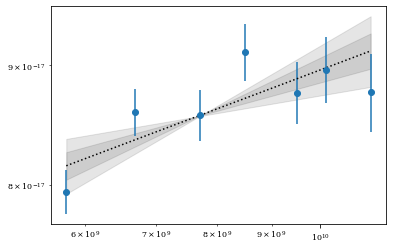

In [4]:
find_photon_index(np.array(list(f_data["frequency"]))*10.**9, convert_y, convert_y_err)

In [5]:
bands = {
    "U": 3465 * u.angstrom,
    "UVW1": 2600 * u.angstrom,
    "UVM2": 2246 * u.angstrom,
    "UVW2": 1928 * u.angstrom,
    "g.ZTF": 464 * u.nm,
    "r.ZTF": 658 * u.nm,
    "r.SEDm": 658 * u.nm,
}

colors = {
    "r.IOO": "r",
    "r.ZTF": "r",
    "r.SEDM": "r",
    "g.ZTF": "g",
    "g.IOO": "g",
    "UVW2": "violet",
    "UVM2": "purple",
    "UVW1": "darkblue",
    "U": "blue",
    
}

0.961130583236782
Gradient = 1.10 +/- 1.16
Photon Index = -0.90 +/- 1.16
0.9390296218779794
Gradient = 2.26 +/- 0.63
Photon Index = 0.26 +/- 0.63
8.160082054509132e-10
Gradient = 2.55 +/- 0.36
Photon Index = 0.55 +/- 0.36
4.225318850359372e-08
Gradient = 2.12 +/- 0.28
Photon Index = 0.12 +/- 0.28
0.9517401427697365
Gradient = 1.93 +/- 0.65
Photon Index = -0.07 +/- 0.65


<ipython-input-6-721f8860401c>:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
<ipython-input-3-cec9345bb23a>:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


7.877351437812763e-08
Gradient = 2.26 +/- 0.24
Photon Index = 0.26 +/- 0.24
0.8834783738668817
Gradient = 2.11 +/- 0.29
Photon Index = 0.11 +/- 0.29
0.9032637261665797
Gradient = 2.17 +/- 0.29
Photon Index = 0.17 +/- 0.29
0.8362924293573049
Gradient = 2.03 +/- 0.31
Photon Index = 0.03 +/- 0.31
1.59847926006762e-08
Gradient = 2.36 +/- 0.18
Photon Index = 0.36 +/- 0.18
0.959276555547376
Gradient = 0.71 +/- 1.16

/usr/local/anaconda3/envs/bran_stark_paper/lib/python3.8/site-packages/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',



Photon Index = -1.29 +/- 1.16
0.8845198414505311
Gradient = 2.16 +/- 0.30
Photon Index = 0.16 +/- 0.30
0.9600924464221554
Gradient = 0.61 +/- 1.16
Photon Index = -1.39 +/- 1.16
1.229464752228182e-09
Gradient = 2.64 +/- 0.18
Photon Index = 0.64 +/- 0.18
1.2681916627954593e-10
Gradient = 2.75 +/- 0.49
Photon Index = 0.75 +/- 0.49
5.838745742448026e-08
Gradient = 2.50 +/- 0.27
Photon Index = 0.50 +/- 0.27
1.8966761161642864e-08
Gradient = 2.39 +/- 0.23
Photon Index = 0.39 +/- 0.23
0.9713607017642981
Gradient = 1.96 +/- 1.36
Photon Index = -0.04 +/- 1.36
0.9389580991681352
Gradient = 2.23 +/- 1.38
Photon Index = 0.23 +/- 1.38
3.236529266814614e-09
Gradient = 2.51 +/- 0.30
Photon Index = 0.51 +/- 0.30
0.8870216035559186
Gradient = 1.92 +/- 0.46
Photon Index = -0.08 +/- 0.46
0.9272068067393506
Gradient = 2.32 +/- 0.95
Photon Index = 0.32 +/- 0.95
0.9199432246282225
Gradient = 1.19 +/- 1.78
Photon Index = -0.81 +/- 1.78
0.7605228300237497
Gradient = 1.53 +/- 1.04
Photon Index = -0.47 +/- 1.0

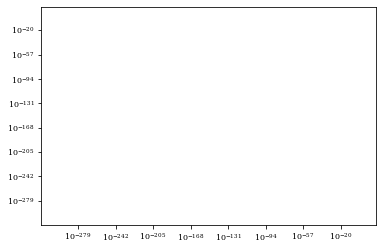

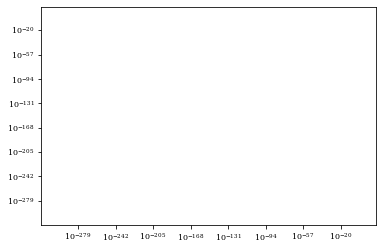

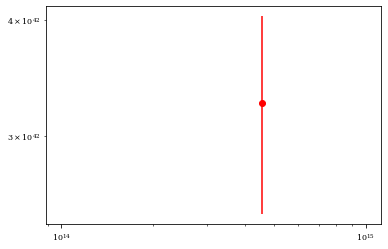

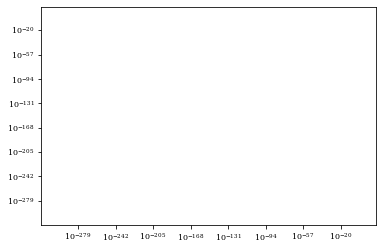

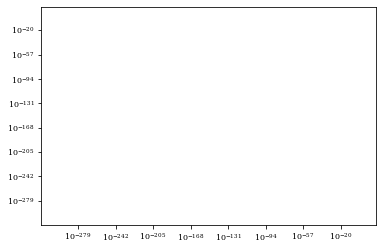

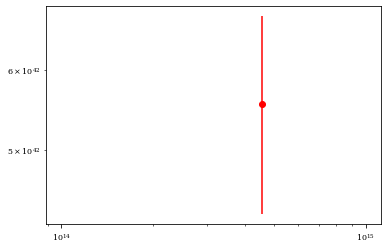

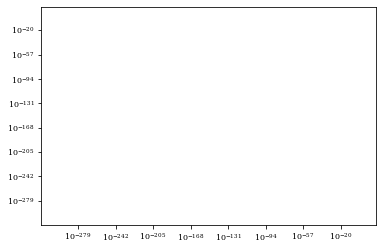

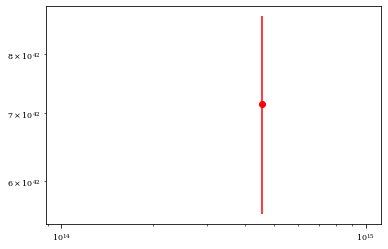

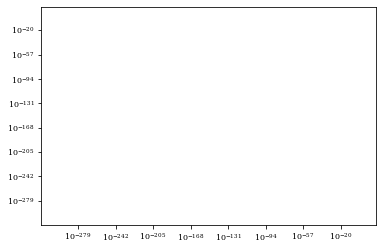

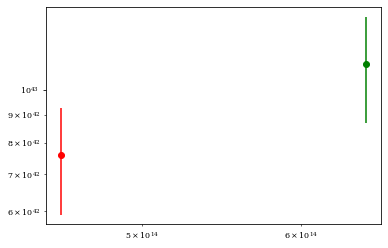

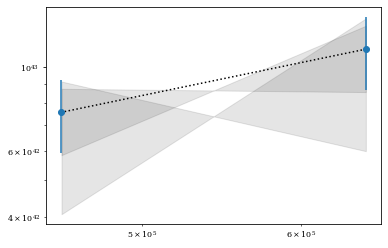

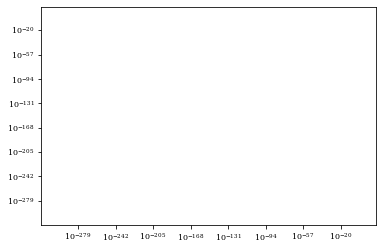

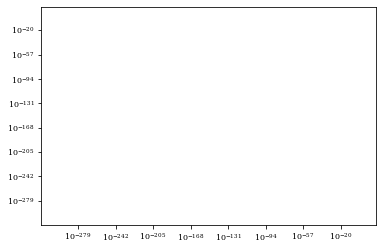

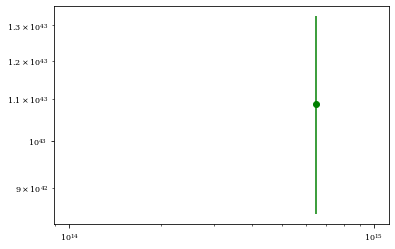

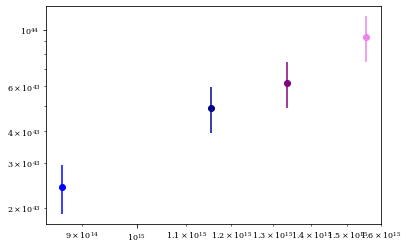

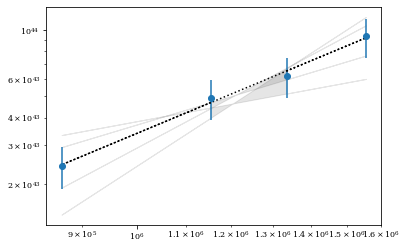

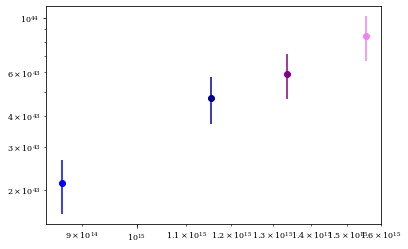

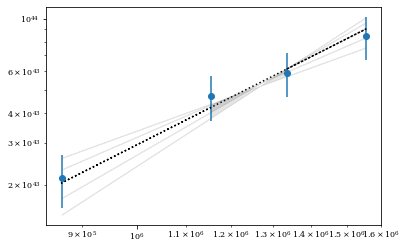

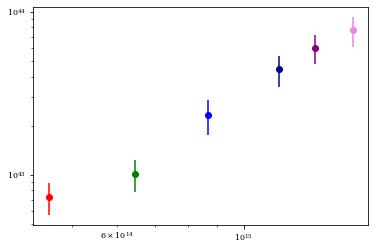

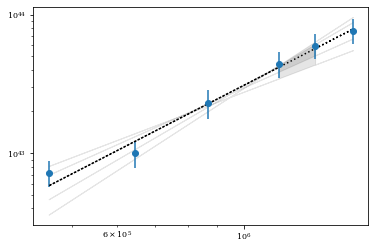

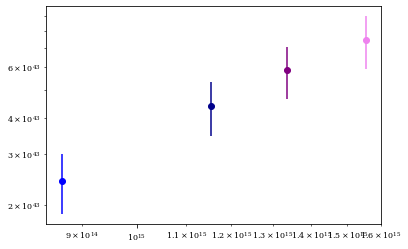

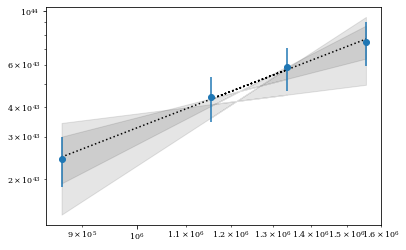

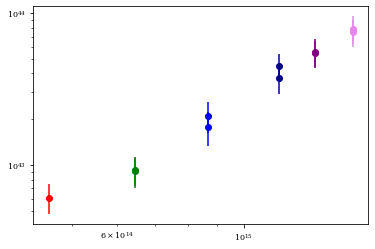

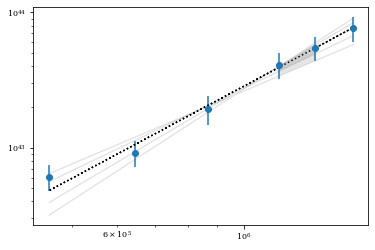

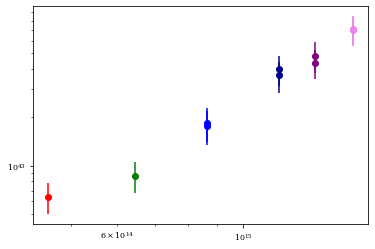

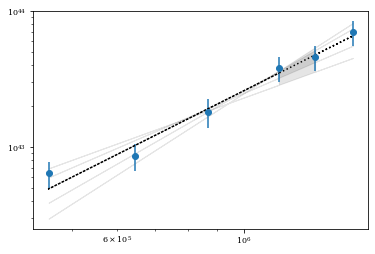

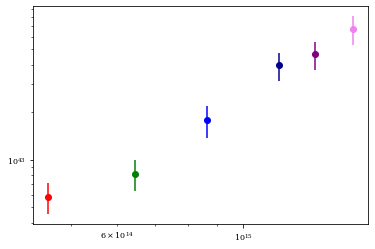

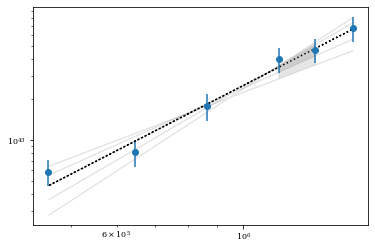

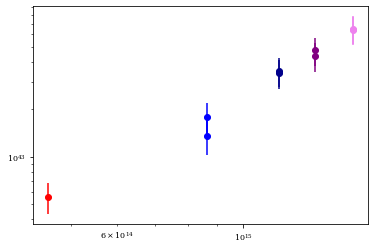

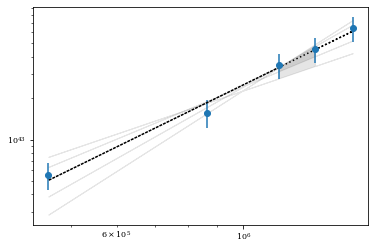

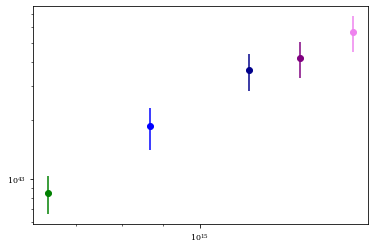

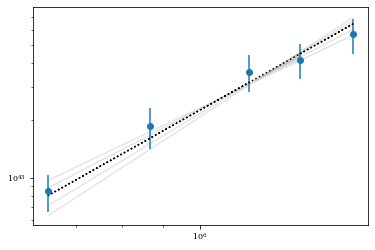

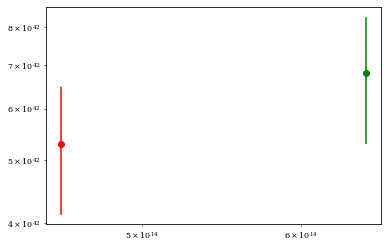

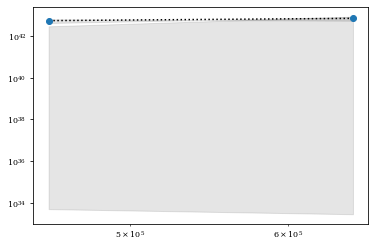

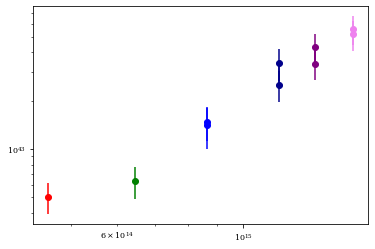

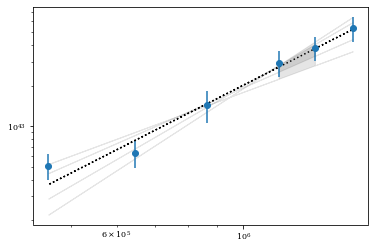

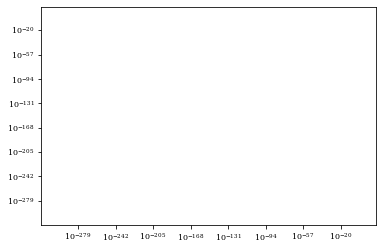

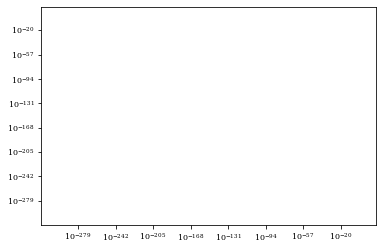

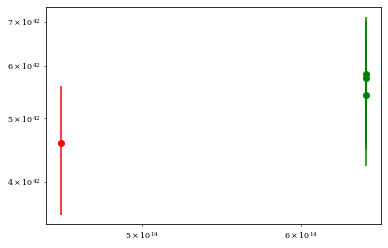

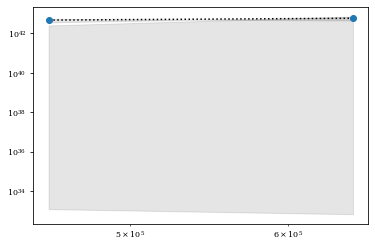

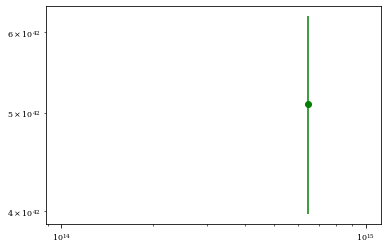

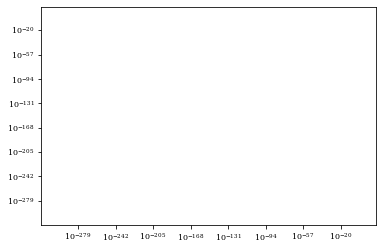

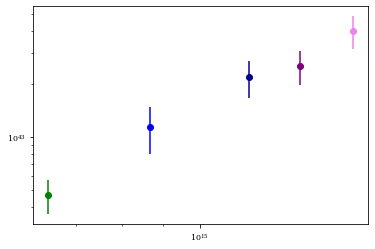

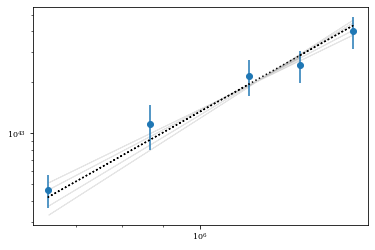

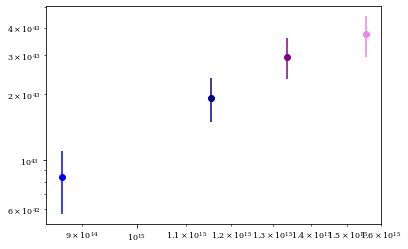

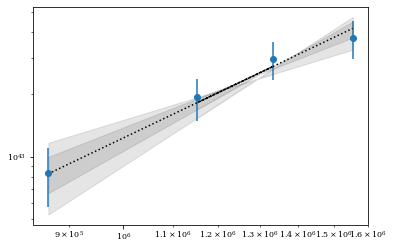

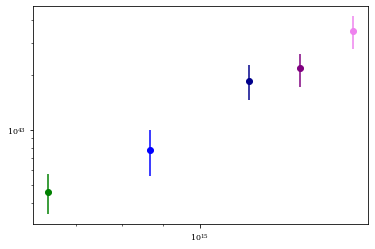

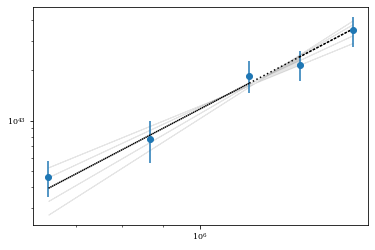

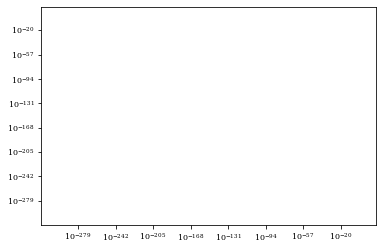

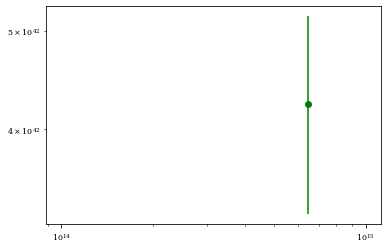

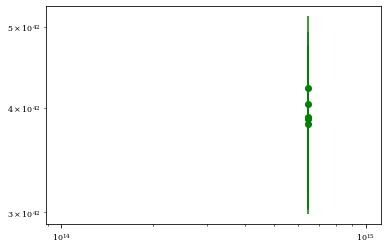

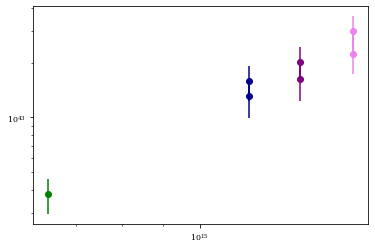

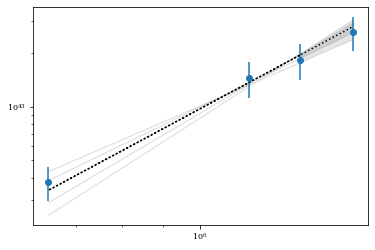

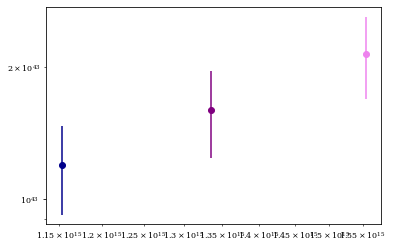

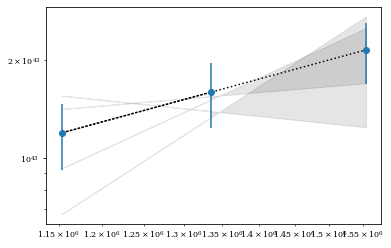

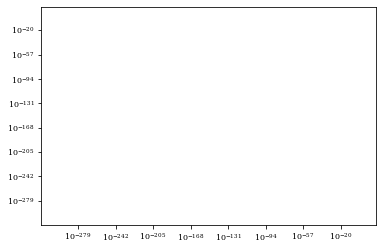

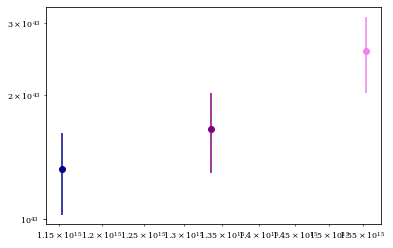

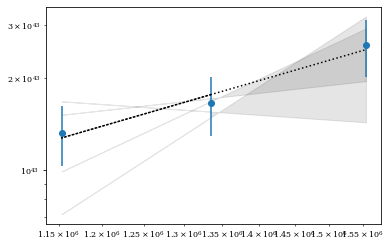

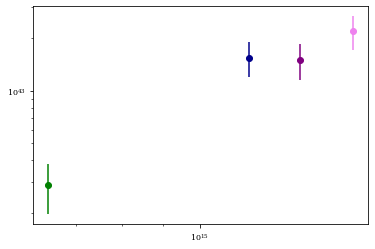

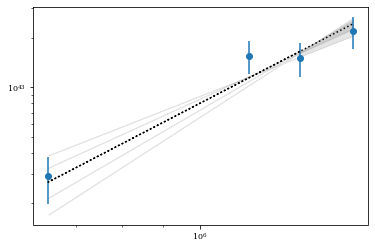

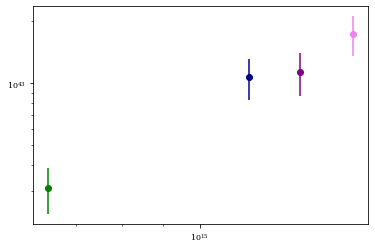

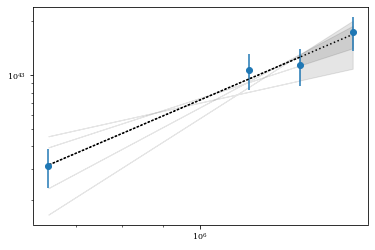

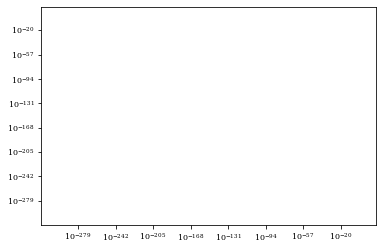

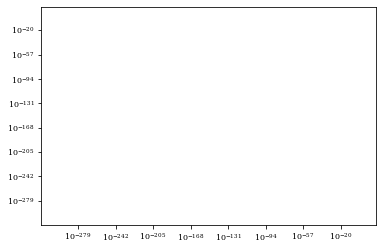

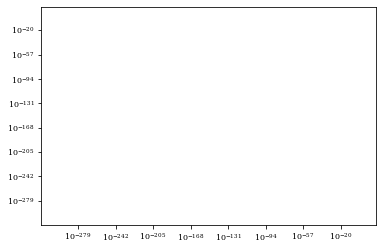

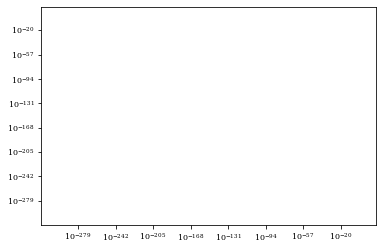

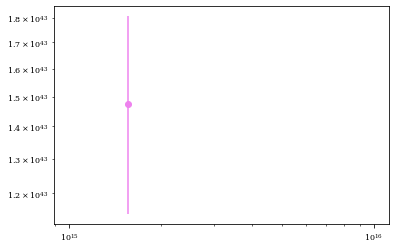

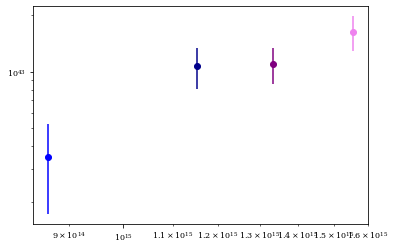

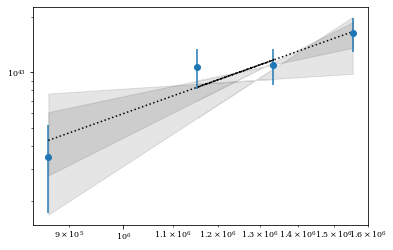

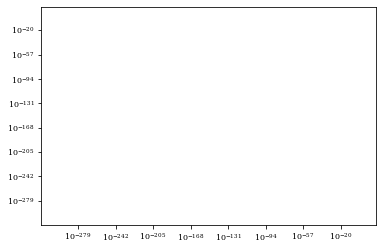

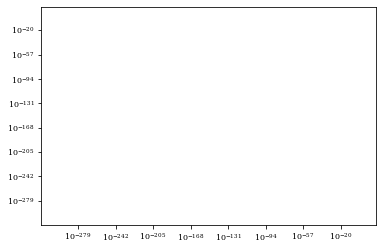

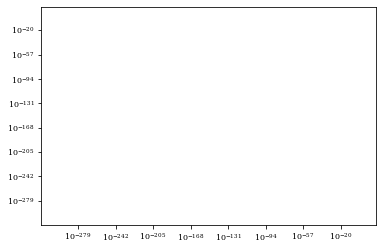

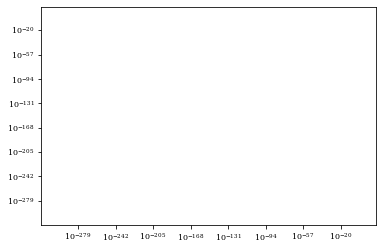

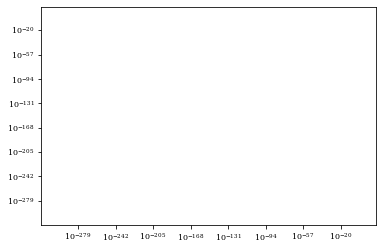

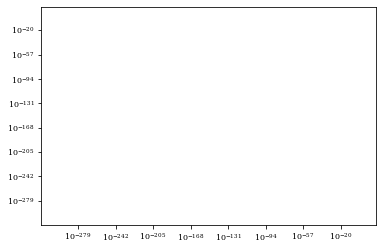

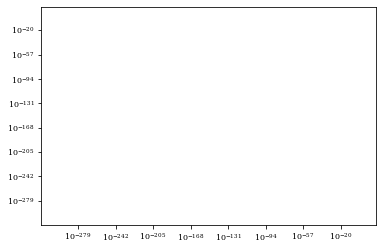

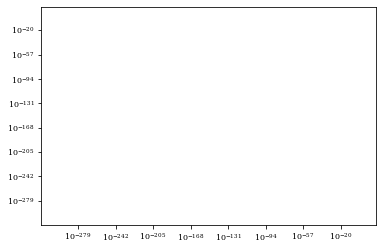

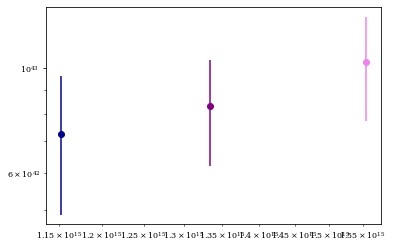

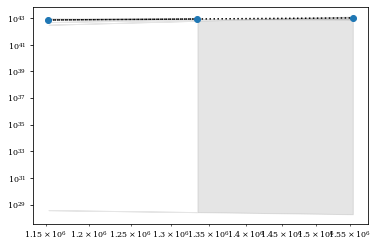

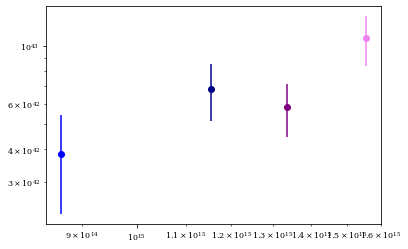

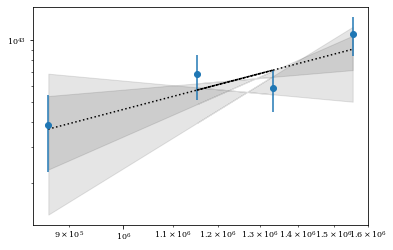

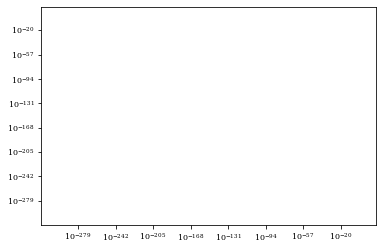

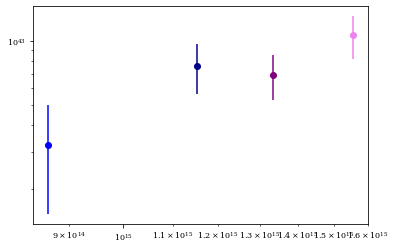

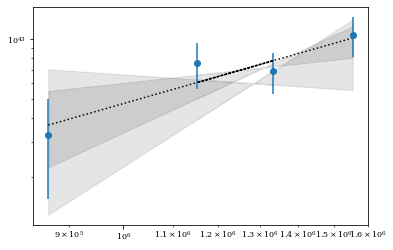

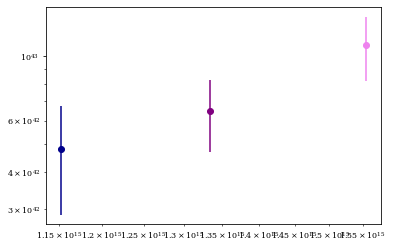

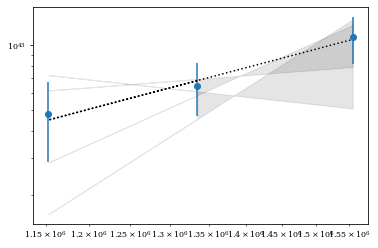

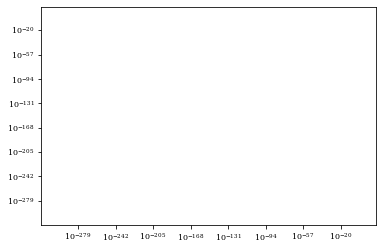

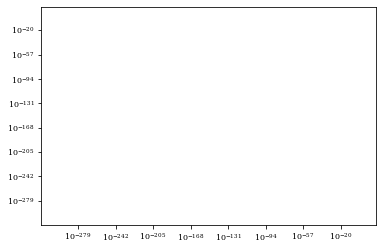

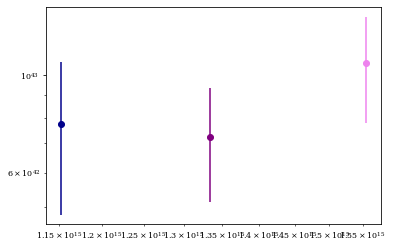

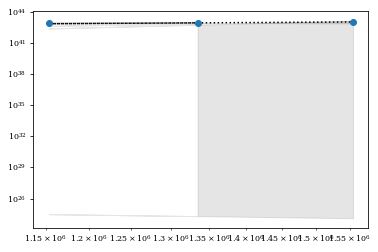

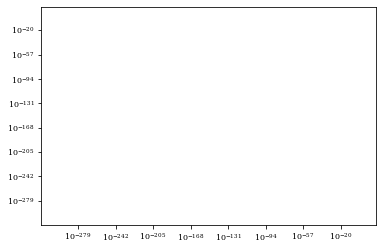

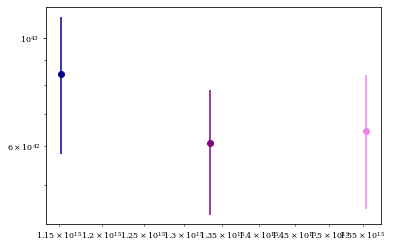

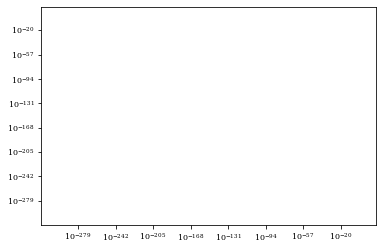

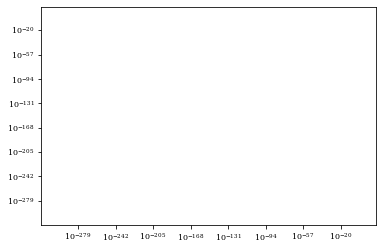

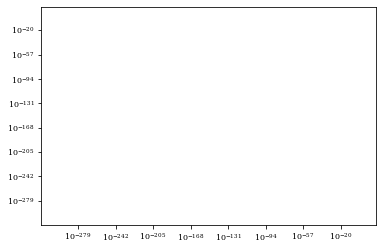

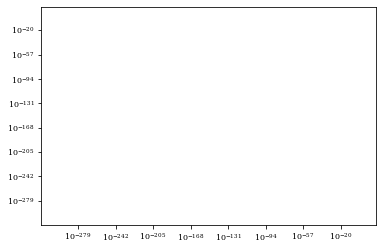

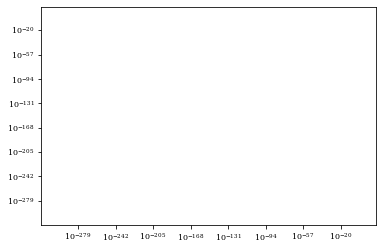

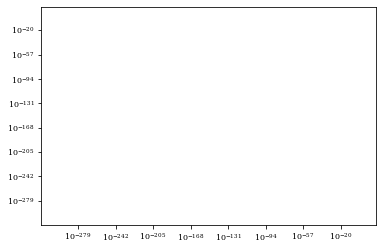

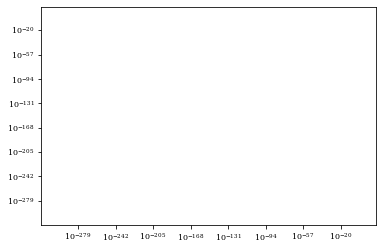

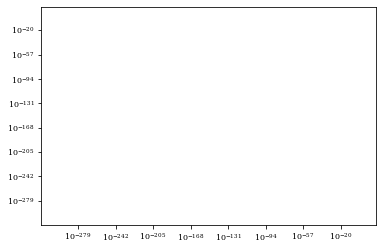

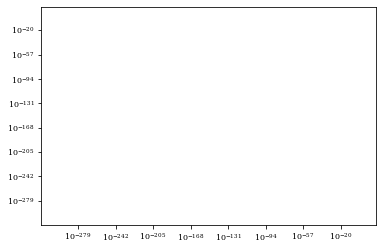

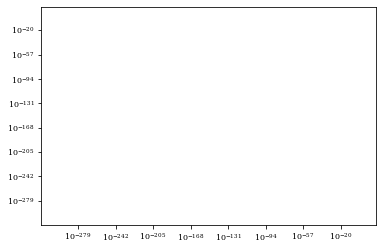

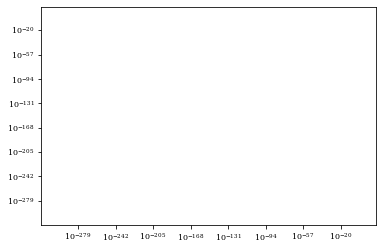

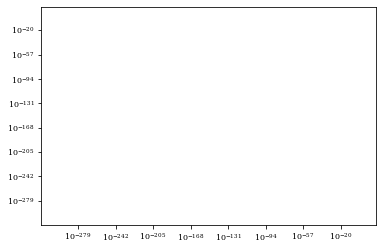

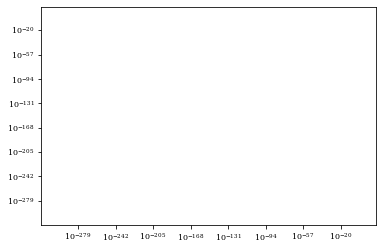

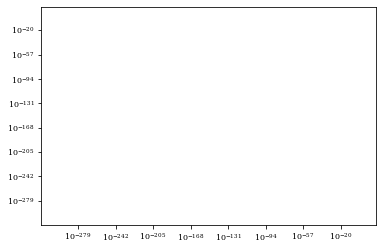

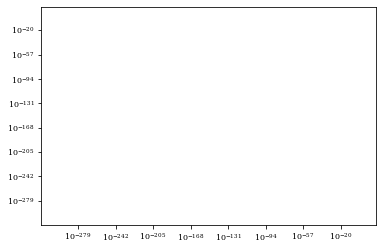

In [6]:
cmap = "plasma"
bins = np.linspace(min(photometry_data["#day_since_peak"]), max(photometry_data["#day_since_peak"]) + 50., 81)

index_times = []
photon_index = []
errs = []

ls_times = []
ls_index = []
ls_errs = []

for j, lower in enumerate(bins[:-1]):
    plt.figure()
    ax = plt.subplot(111)
    time_scale = bins[-1] - bins[0] 
    lower = bins[j]
    upper = bins[j + 1]
    mask = np.logical_and(
            photometry_data["#day_since_peak"] > lower,
            photometry_data["#day_since_peak"] < upper,
        )
                
    data = photometry_data[mask]
    
    fs = []
    lums = []
    yerrs = []

    for band in list(set(data["band"][mask])):
        if band in bands:
            wl = bands[band].to("m")
            f = (const.c / wl).to("Hz")
            
            bmask = np.logical_and(
                data["band"] == band,
                data["lum"] > 0.
            )

            bd = data[bmask]["lum"]
            err = np.sqrt(data[bmask]["err_lum"]**2. + (0.2*data[bmask]["lum"])**2.)
#             bd = np.array(list(bd[bd > 0]))
                
            x = np.ones_like(bd) * f.value
            if len(bd) > 0:
                ax.errorbar(
                    x,
                    bd,
                    yerr=err,
                    marker="o",
                    c=colors[band]
#                     c=data[bmask]["#day_since_peak"],
#                     vmin=bins[0],
#                     vmax=bins[-1],
#                     cmap=cmap
                ) 
                fs.append(f.value)
                lums.append(np.mean(bd))
                yerrs.append(np.mean(err))
                
    plt.yscale("log")
    plt.xscale("log")
   
    
    if len(fs) > 1:
        
        min_x = min(fs)
        max_x = max(fs)
        
        grad = (np.log(max(lums)) - np.log(min(lums)))/(np.log(max(fs)) - np.log(min(fs)))
                
        def f(x):
            return np.exp(np.log(min(lums)) + grad * (np.log(x) - np.log(min(fs))))
        
        x = [min_x, max_x]

#         plt.plot(
#             x,
#             f(x),
#             linestyle=":", 
#             c=matplotlib.cm.get_cmap(cmap)((np.mean([lower, upper]) - bins[0])/time_scale)
#         )
        
        try:
        
            grad, err = find_photon_index(np.array(fs)/10.**9, lums, yerrs)
            
            if len(fs) > 3:
                index_times.append(np.mean([lower, upper]))
                photon_index.append(grad)
                errs.append(err)
            else:
                ls_times.append(np.mean([lower, upper]))
                ls_index.append(grad)
                ls_errs.append(err)
            
        except RuntimeError:
            print("Failed")
            pass
        

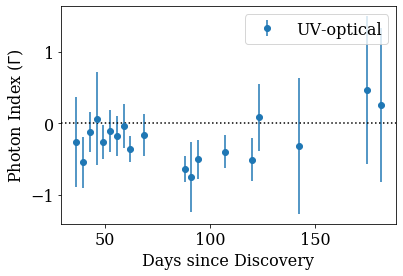

In [19]:
t_offset = bran_disc.mjd - t_peak_mjd.mjd

fontsize=16

plt.figure()
ax = plt.subplot(111)
plt.errorbar(index_times - t_offset, -np.array(photon_index), yerr=errs, marker="o", fmt=" ", label="UV-optical")
# plt.errorbar(ls_times - t_offset, ls_index, yerr=ls_errs, marker="o", fmt=" ")
plt.axhline(0.0, linestyle=":", color="k")
plt.legend(fontsize=fontsize)
plt.ylabel(r"Photon Index ($\Gamma$)", fontsize=fontsize)
plt.xlabel("Days since Discovery", fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
plt.savefig("plots/photon_index.pdf")

<ErrorbarContainer object of 3 artists>

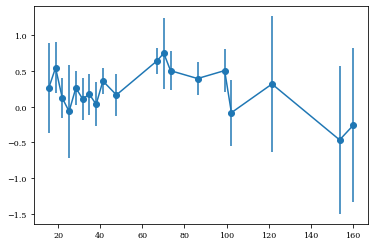

In [8]:
plt.errorbar(index_times, photon_index, yerr=errs, marker="o")